<a href="https://colab.research.google.com/github/KOTHAKOTESH/DISSERTATION/blob/main/KOTHAKOTESH_DISSERTATIONCODE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install mlxtend

In [2]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.cluster import KMeans
import scipy.cluster.hierarchy as sch
from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
from sklearn.decomposition import PCA

In [5]:
# Load the dataset from a xlsx file
file_path = "Online Retail.xlsx"
df = pd.read_excel(file_path, engine="openpyxl")

# Display the first few rows of the dataset
print("Dataset Overview:")
print(df.head())

# Show basic dataset information
print("\nDataset Info:")
print(df.info())

# Check for missing values
print("\nMissing Values in Dataset:")
print(df.isnull().sum())

# Summary statistics of numerical columns
print("\nStatistical Summary:")
print(df.describe())

# Display the column names
print("\nColumn Names in Dataset:")
print(df.columns)

Dataset Overview:
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype      

In [6]:
# Drop rows where 'Description' is missing
df = df.dropna(subset=['Description'])

# Drop rows where 'CustomerID' is missing (optional)
df = df.dropna(subset=['CustomerID'])

# Convert 'CustomerID' to integer
df['CustomerID'] = df['CustomerID'].astype(int)

# Remove duplicates
df = df.drop_duplicates()

# Remove negative Quantity and UnitPrice
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

# Create 'TotalPrice' column
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# Identify and filter out canceled invoices (InvoiceNo starting with 'C')
df['InvoiceNo'] = df['InvoiceNo'].astype(str)
df = df[~df['InvoiceNo'].str.startswith('C')]

# Reset index after cleaning
df = df.reset_index(drop=True)

# Display cleaned dataset summary
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392692 entries, 0 to 392691
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    392692 non-null  object        
 1   StockCode    392692 non-null  object        
 2   Description  392692 non-null  object        
 3   Quantity     392692 non-null  int64         
 4   InvoiceDate  392692 non-null  datetime64[ns]
 5   UnitPrice    392692 non-null  float64       
 6   CustomerID   392692 non-null  int64         
 7   Country      392692 non-null  object        
 8   TotalPrice   392692 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 27.0+ MB
None
            Quantity                    InvoiceDate      UnitPrice  \
count  392692.000000                         392692  392692.000000   
mean       13.119702  2011-07-10 19:13:07.771892480       3.125914   
min         1.000000            2010-12-01 

In [7]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


In [8]:
# Convert 'InvoiceDate' to datetime (if not already)
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Convert categorical columns to string before encoding
df['StockCode'] = df['StockCode'].astype(str)
df['Description'] = df['Description'].astype(str)
df['Country'] = df['Country'].astype(str)

# Apply Label Encoding
label_encoders = {}
categorical_cols = ['Country', 'Description', 'StockCode']

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])  # Convert to numeric labels
    label_encoders[col] = le  # Store encoder for future use

# Reset index after cleaning
df = df.reset_index(drop=True)

# Display final data types
print(df.dtypes)

# Display first few rows of processed dataset
print(df.head())

InvoiceNo              object
StockCode               int64
Description             int64
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID              int64
Country                 int64
TotalPrice            float64
dtype: object
  InvoiceNo  StockCode  Description  Quantity         InvoiceDate  UnitPrice  \
0    536365       3233         3698         6 2010-12-01 08:26:00       2.55   
1    536365       2643         3706         6 2010-12-01 08:26:00       3.39   
2    536365       2847          858         8 2010-12-01 08:26:00       2.75   
3    536365       2795         1804         6 2010-12-01 08:26:00       3.39   
4    536365       2794         2763         6 2010-12-01 08:26:00       3.39   

   CustomerID  Country  TotalPrice  
0       17850       35       15.30  
1       17850       35       20.34  
2       17850       35       22.00  
3       17850       35       20.34  
4       17850       35       20.34  


<ipython-input-9-598b9eb592d3>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_products.values, y=top_products.index, palette="viridis")


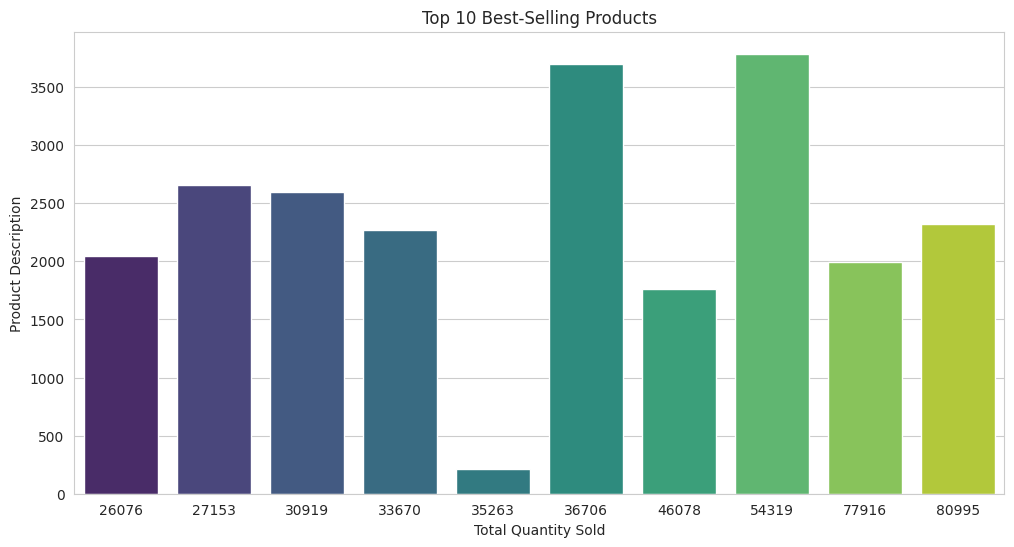

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set Seaborn style
sns.set_style("whitegrid")

# Top 10 Best-Selling Products
top_products = df.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(12,6))
sns.barplot(x=top_products.values, y=top_products.index, palette="viridis")
plt.xlabel("Total Quantity Sold")
plt.ylabel("Product Description")
plt.title("Top 10 Best-Selling Products")
plt.show()

<ipython-input-10-365c3c87851f>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=country_sales.index, y=country_sales.values, palette="coolwarm")


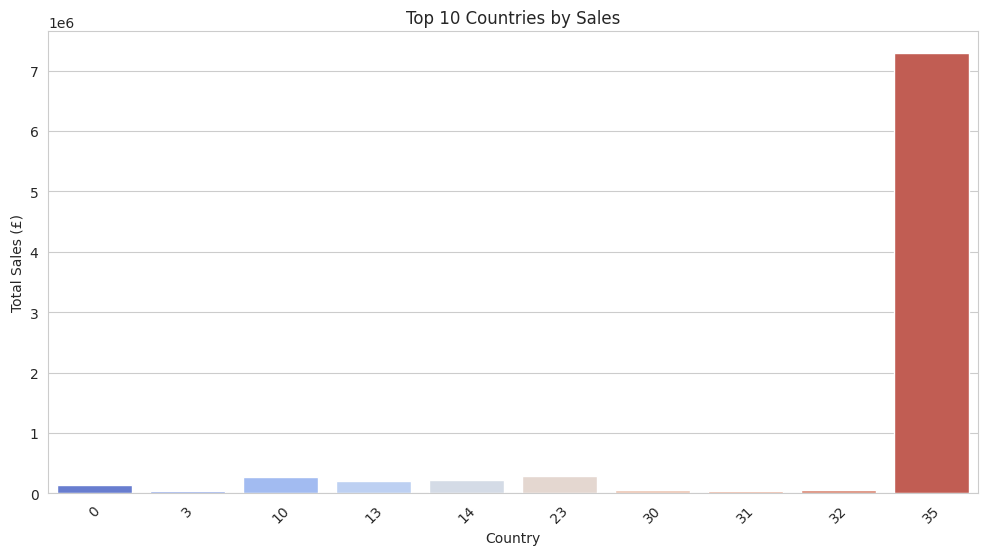

In [10]:
#  Sales Distribution by Country
country_sales = df.groupby('Country')['TotalPrice'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(12,6))
sns.barplot(x=country_sales.index, y=country_sales.values, palette="coolwarm")
plt.xticks(rotation=45)
plt.xlabel("Country")
plt.ylabel("Total Sales (£)")
plt.title("Top 10 Countries by Sales")
plt.show()

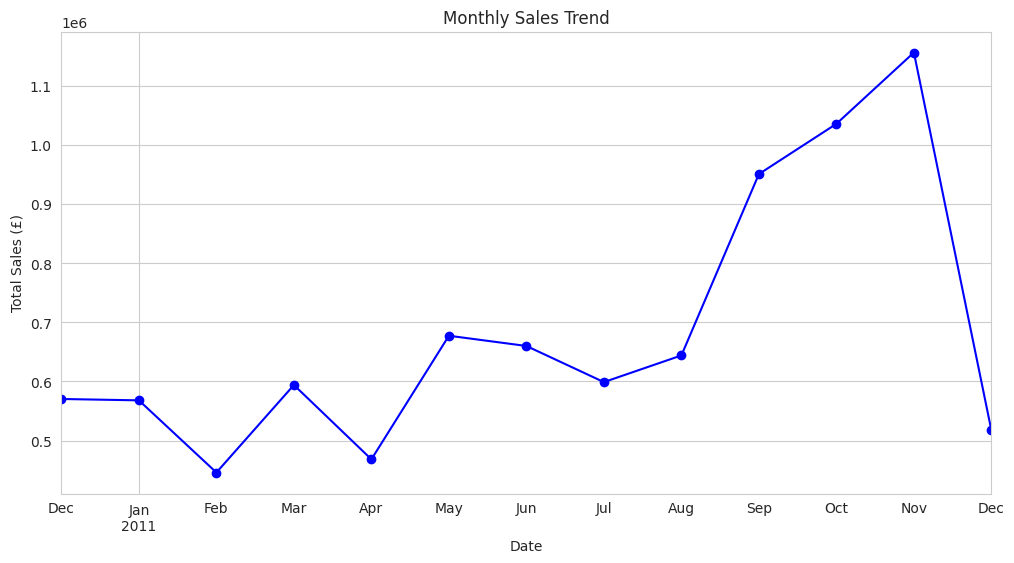

In [11]:
#  Time Series Analysis of Sales
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])  # Ensure datetime format
df['YearMonth'] = df['InvoiceDate'].dt.to_period('M')  # Extract Year-Month
monthly_sales = df.groupby('YearMonth')['TotalPrice'].sum()

plt.figure(figsize=(12,6))
monthly_sales.plot(kind='line', marker='o', color='b')
plt.xlabel("Date")
plt.ylabel("Total Sales (£)")
plt.title("Monthly Sales Trend")
plt.grid(True)
plt.show()

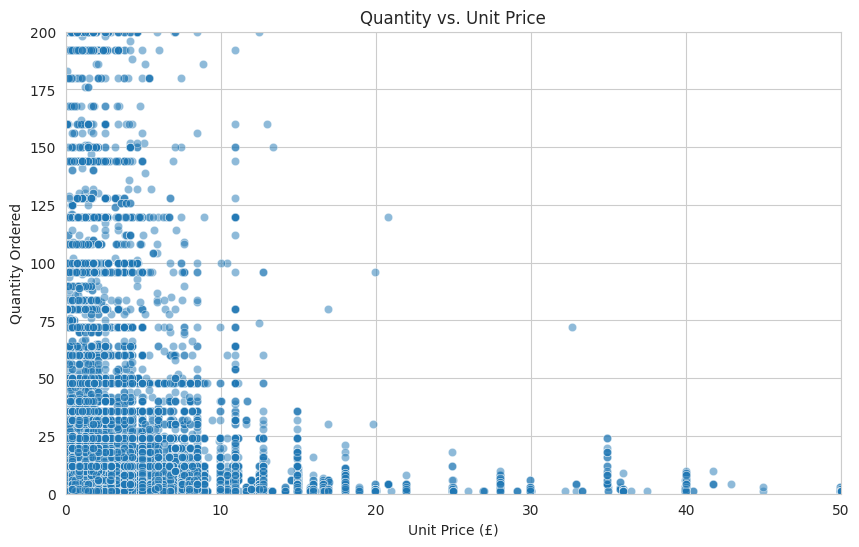

In [12]:
#  Quantity vs. Unit Price Scatter Plot
plt.figure(figsize=(10,6))
sns.scatterplot(x=df['UnitPrice'], y=df['Quantity'], alpha=0.5)
plt.xlim(0, 50)  # Focus on reasonable prices
plt.ylim(0, 200)  # Focus on reasonable quantities
plt.xlabel("Unit Price (£)")
plt.ylabel("Quantity Ordered")
plt.title("Quantity vs. Unit Price")
plt.show()

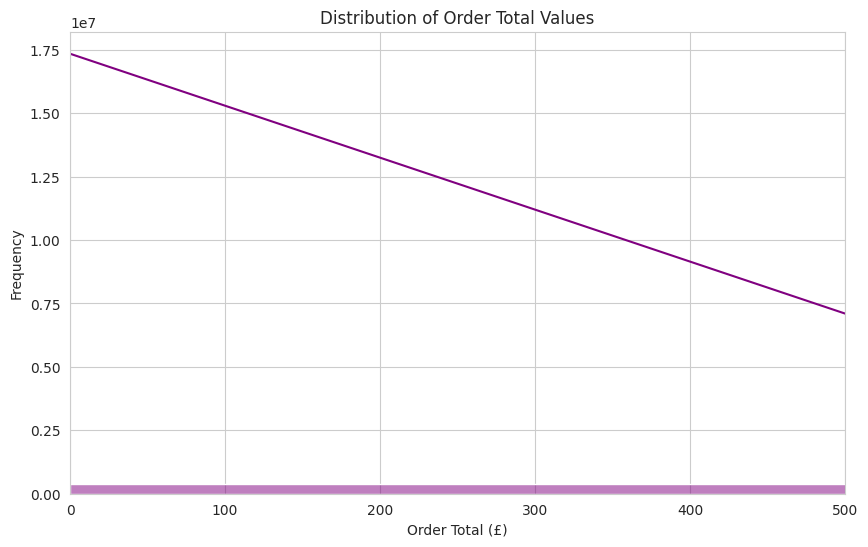

In [13]:
#  Customer Purchase Behavior (Histogram)
plt.figure(figsize=(10,6))
sns.histplot(df['TotalPrice'], bins=50, kde=True, color='purple')
plt.xlim(0, 500)  # Focus on normal purchases
plt.xlabel("Order Total (£)")
plt.ylabel("Frequency")
plt.title("Distribution of Order Total Values")
plt.show()

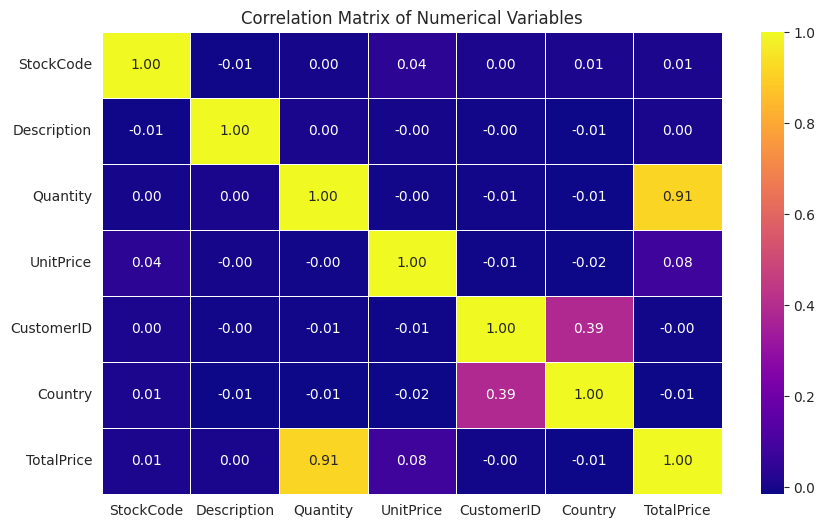

In [14]:
# Select only numerical columns
numeric_df = df.select_dtypes(include=['int64', 'float64'])

# Compute correlation matrix
corr_matrix = numeric_df.corr()

# Plot heatmap
plt.figure(figsize=(10,6))
sns.heatmap(corr_matrix, annot=True, cmap="plasma", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Numerical Variables")
plt.show()

In [15]:
# Avg Basket Value per Invoice
basket_value = df.groupby('InvoiceNo')['TotalPrice'].sum().reset_index()
basket_value.rename(columns={'TotalPrice': 'AvgBasketValue'}, inplace=True)
df = df.merge(basket_value, on='InvoiceNo', how='left')

#  Customer-Based Features
customer_spending = df.groupby('CustomerID')['TotalPrice'].sum().reset_index()
customer_spending.rename(columns={'TotalPrice': 'TotalSpendingPerCustomer'}, inplace=True)
df = df.merge(customer_spending, on='CustomerID', how='left')

order_frequency = df.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
order_frequency.rename(columns={'InvoiceNo': 'OrderFrequency'}, inplace=True)
df = df.merge(order_frequency, on='CustomerID', how='left')

df['AvgOrderValue'] = df['TotalSpendingPerCustomer'] / df['OrderFrequency']

#  Time-Based Features
df['Year'] = df['InvoiceDate'].dt.year
df['Month'] = df['InvoiceDate'].dt.month
df['DayOfWeek'] = df['InvoiceDate'].dt.dayofweek
df['Hour'] = df['InvoiceDate'].dt.hour

# Flag for Weekend Purchases
df['WeekendPurchase'] = df['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)

# Recency (Days since last purchase)
latest_date = df['InvoiceDate'].max()
customer_recency = df.groupby('CustomerID')['InvoiceDate'].max().reset_index()
customer_recency['Recency'] = (latest_date - customer_recency['InvoiceDate']).dt.days
df = df.merge(customer_recency[['CustomerID', 'Recency']], on='CustomerID', how='left')

#  Product-Level Features
product_popularity = df.groupby('StockCode')['Quantity'].sum().reset_index()
product_popularity.rename(columns={'Quantity': 'ProductPopularity'}, inplace=True)
df = df.merge(product_popularity, on='StockCode', how='left')

# Identify Returns (Negative Quantities)
df['Returns'] = df['Quantity'].apply(lambda x: 1 if x < 0 else 0)

#  Drop duplicate features to avoid redundancy
df = df.drop_duplicates()

#  Display the final dataset with engineered features
print(df.head())

  InvoiceNo  StockCode  Description  Quantity         InvoiceDate  UnitPrice  \
0    536365       3233         3698         6 2010-12-01 08:26:00       2.55   
1    536365       2643         3706         6 2010-12-01 08:26:00       3.39   
2    536365       2847          858         8 2010-12-01 08:26:00       2.75   
3    536365       2795         1804         6 2010-12-01 08:26:00       3.39   
4    536365       2794         2763         6 2010-12-01 08:26:00       3.39   

   CustomerID  Country  TotalPrice YearMonth  ...  OrderFrequency  \
0       17850       35       15.30   2010-12  ...              34   
1       17850       35       20.34   2010-12  ...              34   
2       17850       35       22.00   2010-12  ...              34   
3       17850       35       20.34   2010-12  ...              34   
4       17850       35       20.34   2010-12  ...              34   

   AvgOrderValue  Year  Month  DayOfWeek  Hour  WeekendPurchase  Recency  \
0        158.565  2010     1

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392692 entries, 0 to 392691
Data columns (total 22 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   InvoiceNo                 392692 non-null  object        
 1   StockCode                 392692 non-null  int64         
 2   Description               392692 non-null  int64         
 3   Quantity                  392692 non-null  int64         
 4   InvoiceDate               392692 non-null  datetime64[ns]
 5   UnitPrice                 392692 non-null  float64       
 6   CustomerID                392692 non-null  int64         
 7   Country                   392692 non-null  int64         
 8   TotalPrice                392692 non-null  float64       
 9   YearMonth                 392692 non-null  period[M]     
 10  AvgBasketValue            392692 non-null  float64       
 11  TotalSpendingPerCustomer  392692 non-null  float64       
 12  Or

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#  Drop non-numeric columns
X = df.drop(columns=['InvoiceNo', 'StockCode', 'Description', 'Country', 'TotalPrice', 'InvoiceDate', 'YearMonth'])
y = df['TotalPrice']  # Target variable

#  Train-Test Split (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#  Apply Standard Scaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#  Display shapes of final datasets
print("Training Features Shape:", X_train_scaled.shape)
print("Testing Features Shape:", X_test_scaled.shape)
print("Training Target Shape:", y_train.shape)
print("Testing Target Shape:", y_test.shape)

Training Features Shape: (314153, 15)
Testing Features Shape: (78539, 15)
Training Target Shape: (314153,)
Testing Target Shape: (78539,)


In [18]:
"""
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

#  Linear Regression
lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled, y_train)
y_pred_lin = lin_reg.predict(X_test_scaled)

#  Random Forest Regressor
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
rf_reg.fit(X_train_scaled, y_train)
y_pred_rf = rf_reg.predict(X_test_scaled)

#  XGBoost Regressor
xgb_reg = XGBRegressor(objective="reg:squarederror", random_state=42)
xgb_reg.fit(X_train_scaled, y_train)
y_pred_xgb = xgb_reg.predict(X_test_scaled)
"""

'\nfrom sklearn.linear_model import LinearRegression\nfrom sklearn.ensemble import RandomForestRegressor\nfrom xgboost import XGBRegressor\nfrom sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score\n\n#  Linear Regression\nlin_reg = LinearRegression()\nlin_reg.fit(X_train_scaled, y_train)\ny_pred_lin = lin_reg.predict(X_test_scaled)\n\n#  Random Forest Regressor\nrf_reg = RandomForestRegressor(n_estimators=100, random_state=42)\nrf_reg.fit(X_train_scaled, y_train)\ny_pred_rf = rf_reg.predict(X_test_scaled)\n\n#  XGBoost Regressor\nxgb_reg = XGBRegressor(objective="reg:squarederror", random_state=42)\nxgb_reg.fit(X_train_scaled, y_train)\ny_pred_xgb = xgb_reg.predict(X_test_scaled)\n'

In [20]:
import joblib

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Check if the model files exist
import os
model_files_exist = all(os.path.exists(file) for file in ["linear_regression_model.pkl", "random_forest_model.pkl", "xgboost_model.pkl"])

if not model_files_exist:
    print("Model files not found. Training and saving models...")
    # Train and save models if they don't exist
    # (Replace this with your actual model training code)

    # Train the Linear Regression model
    lin_reg = LinearRegression()
    lin_reg.fit(X_train_scaled, y_train)

    # Train the Random Forest Regression model
    rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_reg.fit(X_train_scaled, y_train)

    # Train the XGBoost Regression model
    xgb_reg = XGBRegressor(objective="reg:squarederror", random_state=42)
    xgb_reg.fit(X_train_scaled, y_train)

    # Save the trained models
    joblib.dump(lin_reg, "linear_regression_model.pkl")
    joblib.dump(rf_reg, "random_forest_model.pkl")
    joblib.dump(xgb_reg, "xgboost_model.pkl")

# Load the models (if they already existed or were just trained)
lin_reg = joblib.load("linear_regression_model.pkl")
rf_reg = joblib.load("random_forest_model.pkl")
xgb_reg = joblib.load("xgboost_model.pkl")

print("Models loaded successfully!")

Model files not found. Training and saving models...
Models loaded successfully!


In [21]:
# Example: Make predictions using the loaded models
y_pred_lin = lin_reg.predict(X_test_scaled)
y_pred_rf = rf_reg.predict(X_test_scaled)
y_pred_xgb = xgb_reg.predict(X_test_scaled)

# Display the first 5 predictions for each model
print("\n Linear Regression Predictions:", y_pred_lin[:5])
print(" Random Forest Predictions:", y_pred_rf[:5])
print(" XGBoost Predictions:", y_pred_xgb[:5])


 Linear Regression Predictions: [ 8.14271647  3.02617678 28.25342259 29.55521318 16.00400446]
 Random Forest Predictions: [17.7  9.9 30.  13.2 19.8]
 XGBoost Predictions: [17.692844 10.437307 29.296413 14.491598 19.2264  ]


In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

#  Define Evaluation Function
def evaluate_model(y_true, y_pred, model_name):
    # Compute Error Metrics
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = mse ** 0.5
    r2 = r2_score(y_true, y_pred)

    #  Print Metrics
    print(f"\n🔹 {model_name} Evaluation:")
    print(f" Mean Absolute Error (MAE): {mae:.4f}")
    print(f" Mean Squared Error (MSE): {mse:.4f}")
    print(f" Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f" R-squared (R²): {r2:.4f}")

    #  Actual vs Predicted Plot
    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=y_true, y=y_pred, alpha=0.6, color="blue", label="Predicted vs Actual")
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], color="red", linestyle="--", label="Perfect Fit")
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title(f"{model_name} - Actual vs Predicted")
    plt.legend()
    plt.show()

    #  Residual Plot
    residuals = y_true - y_pred
    plt.figure(figsize=(8, 5))
    sns.histplot(residuals, bins=30, kde=True, color="purple", alpha=0.7)
    plt.axvline(0, color="black", linestyle="--", label="Zero Error")
    plt.xlabel("Residuals (Prediction Error)")
    plt.ylabel("Frequency")
    plt.title(f"{model_name} - Residual Plot")
    plt.legend()
    plt.show()


🔹 Random Forest Regressor Evaluation:
 Mean Absolute Error (MAE): 1.7507
 Mean Squared Error (MSE): 173436.4304
 Root Mean Squared Error (RMSE): 416.4570
 R-squared (R²): 0.5271


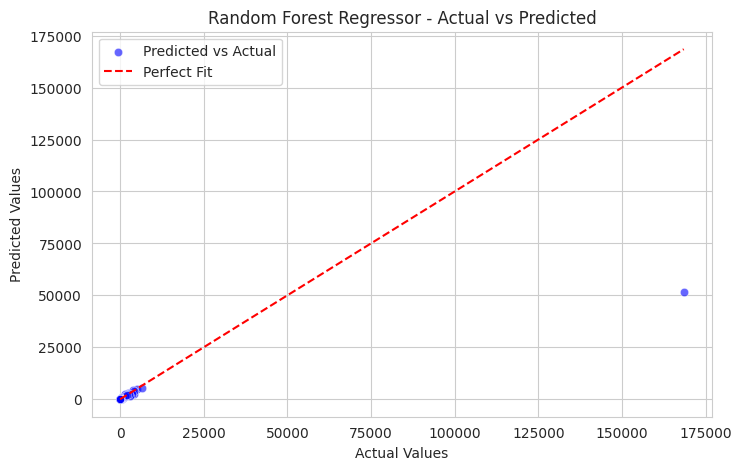

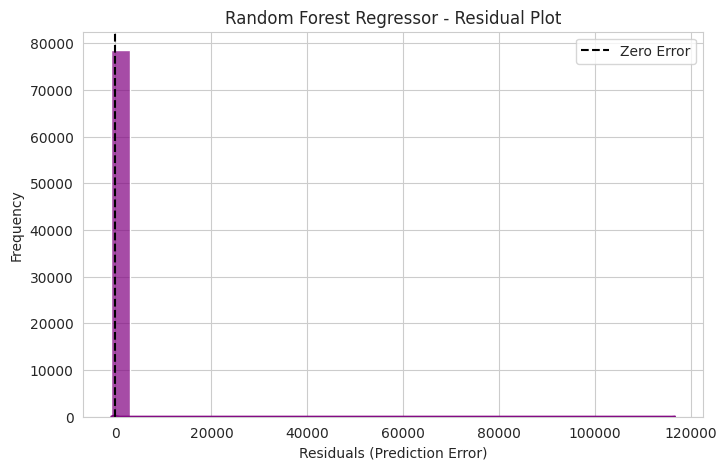

In [23]:
evaluate_model(y_test, y_pred_rf, "Random Forest Regressor")


🔹 XGBoost Regressor Evaluation:
 Mean Absolute Error (MAE): 2.8976
 Mean Squared Error (MSE): 105009.3545
 Root Mean Squared Error (RMSE): 324.0515
 R-squared (R²): 0.7137


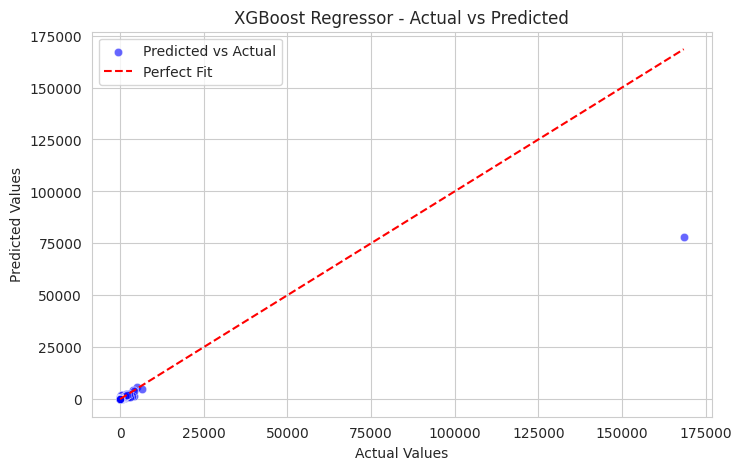

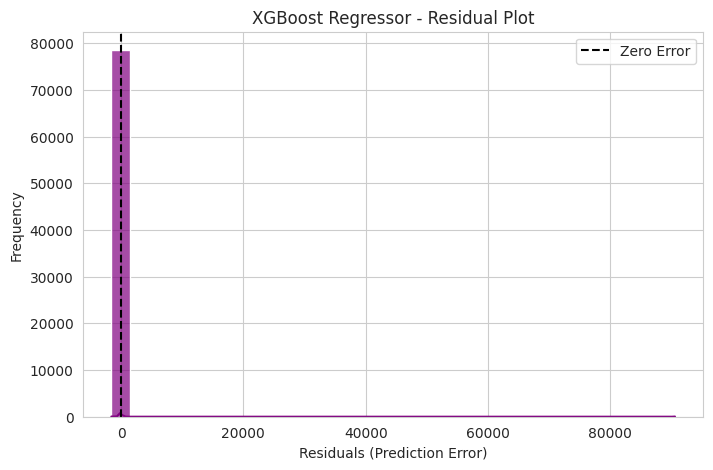

In [24]:
evaluate_model(y_test, y_pred_xgb, "XGBoost Regressor")


🔹 Linear Regressor Evaluation:
 Mean Absolute Error (MAE): 13.9779
 Mean Squared Error (MSE): 91437.2924
 Root Mean Squared Error (RMSE): 302.3860
 R-squared (R²): 0.7507


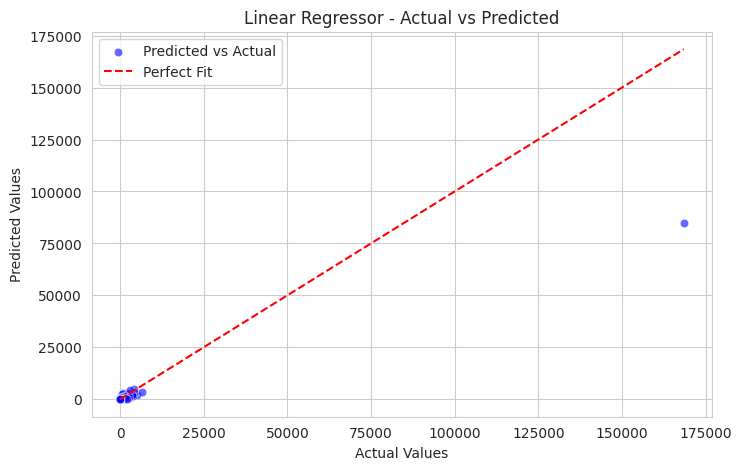

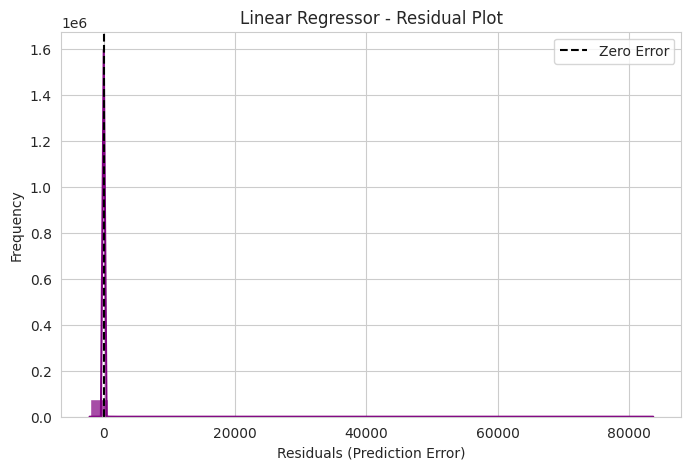

In [25]:
evaluate_model(y_test, y_pred_lin, "Linear Regressor")

In [26]:
import joblib

# Save each model
joblib.dump(lin_reg, "linear_regression_model.pkl")
joblib.dump(rf_reg, "random_forest_model.pkl")
joblib.dump(xgb_reg, "xgboost_model.pkl")

print(" Models saved successfully!")

 Models saved successfully!


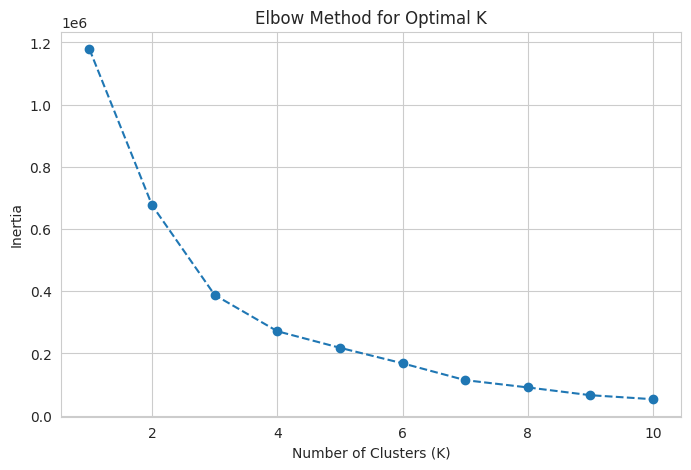

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist

#  Select Features for Clustering (Recency, Frequency, Monetary)
X_cluster = df[['Recency', 'OrderFrequency', 'TotalSpendingPerCustomer']]

#  Standardize the Data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

#  Find Optimal K using the Elbow Method
inertia = []
K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

#  Plot Elbow Curve
plt.figure(figsize=(8,5))
plt.plot(K_range, inertia, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.show()

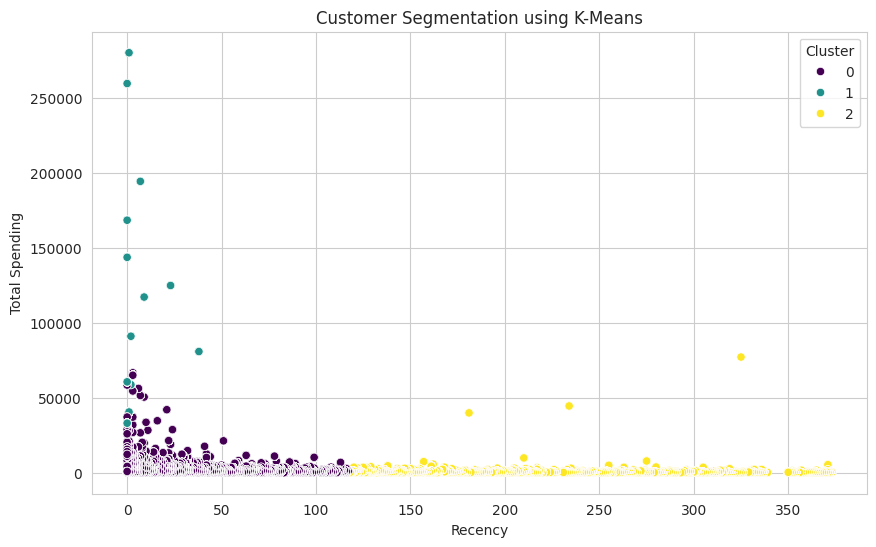

In [28]:
# Apply K-Means with Optimal K
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)  # Ensure `n_init` to avoid warnings
df['Cluster_KMeans'] = kmeans.fit_predict(X_scaled)

# Visualize K-Means Clusters
plt.figure(figsize=(10,6))
sns.scatterplot(x=df['Recency'], y=df['TotalSpendingPerCustomer'], hue=df['Cluster_KMeans'], palette='viridis')
plt.title('Customer Segmentation using K-Means')
plt.xlabel('Recency')
plt.ylabel('Total Spending')
plt.legend(title="Cluster")
plt.show()

In [29]:
#  Display Cluster Statistics
print(df.groupby('Cluster_KMeans').agg({'Recency': 'mean', 'OrderFrequency': 'mean', 'TotalSpendingPerCustomer': 'mean'}))

                   Recency  OrderFrequency  TotalSpendingPerCustomer
Cluster_KMeans                                                      
0                23.420193       10.820918               5691.575587
1                 1.985728      132.914226              93998.315721
2               214.114806        2.760824               1044.681479


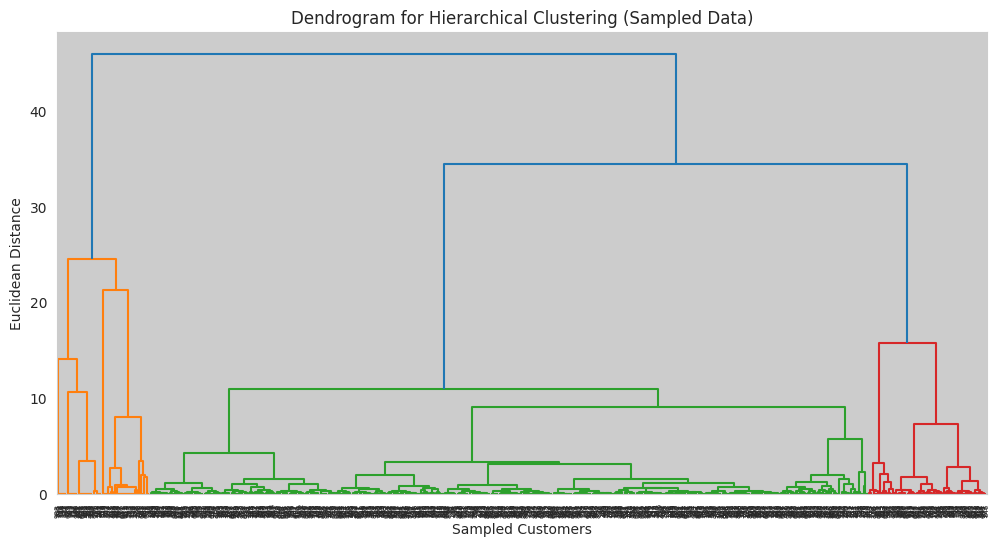

In [30]:
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score

#   Reduce dataset for Dendrogram (Sample 1000 points max)
sample_size = min(1000, X_scaled.shape[0])  # Take max 1000 points
X_sample = X_scaled[np.random.choice(X_scaled.shape[0], sample_size, replace=False), :]

#   Plot Dendrogram (Reduced Data)
plt.figure(figsize=(12, 6))
dendrogram = sch.dendrogram(sch.linkage(X_sample, method='ward'))
plt.title('Dendrogram for Hierarchical Clustering (Sampled Data)')
plt.xlabel('Sampled Customers')
plt.ylabel('Euclidean Distance')
plt.show()

In [32]:
from sklearn.metrics import davies_bouldin_score
import numpy as np

# Ensure valid cluster labels (remove -1 if present)
valid_kmeans = df[df['Cluster_KMeans'] != -1]

# Calculate Davies-Bouldin Index (Lower is Better)
dbi_kmeans = davies_bouldin_score(X_scaled[valid_kmeans.index], valid_kmeans['Cluster_KMeans'])

print(f'Davies-Bouldin Index - KMeans: {dbi_kmeans:.4f}')

Davies-Bouldin Index - KMeans: 0.6653


In [34]:
import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules

# ----- Step 1: Sample the Data to Reduce Size -----
df_sample = df.sample(n=2000, random_state=42)  # Use 2000 transactions

# ----- Step 2: Select and Clean Columns -----
# Use only the needed columns and drop rows missing InvoiceNo (transaction identifier)
df_filtered = df_sample[['InvoiceNo', 'Description', 'Quantity']].copy()
df_filtered = df_filtered.dropna(subset=['InvoiceNo'])

# Convert InvoiceNo and Description to string type
df_filtered['InvoiceNo'] = df_filtered['InvoiceNo'].astype(str)
df_filtered['Description'] = df_filtered['Description'].astype(str)

# ----- Step 3: Create Basket Format (One-Hot Encoded Matrix) -----
# Pivot the table: rows as InvoiceNo, columns as Description, values are sum of Quantity
basket = df_filtered.pivot_table(index='InvoiceNo',
                                 columns='Description',
                                 values='Quantity',
                                 aggfunc='sum').fillna(0)

# Convert quantities to binary (True if item was bought, False otherwise)
basket = (basket > 0)

# Filter out rarely purchased items (keep items bought in at least 3 transactions)
basket = basket.loc[:, basket.sum(axis=0) >= 3]
print("Basket shape after filtering:", basket.shape)

# ----- Step 4: Apply Apriori Algorithm -----
# Dynamically adjust min_support (ensuring at least 3 transactions support an item)
min_support_value = max(0.005, 3 / len(basket))
print("Using min_support:", min_support_value)

frequent_itemsets = apriori(basket, min_support=min_support_value, use_colnames=True)
print("Frequent itemsets found:", frequent_itemsets.shape[0])

if frequent_itemsets.empty:
    print("No frequent itemsets found. Try lowering the min_support threshold further.")
else:
    # ----- Step 5: Generate Association Rules -----
    # First try using a lift threshold of 1.0
    rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)

    # If no rules are found, try with a confidence threshold of 0.1
    if rules.empty:
        print("No rules found using lift threshold. Trying with confidence threshold 0.1...")
        rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.1)

    if rules.empty:
        print("No association rules found even after lowering thresholds.")
    else:
        rules = rules.sort_values(by="lift", ascending=False).head(10)  # Top 10 rules
        print("\n** Top 10 Association Rules **")
        print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']])

Basket shape after filtering: (1766, 212)
Using min_support: 0.005
Frequent itemsets found: 2
No rules found using lift threshold. Trying with confidence threshold 0.1...
No association rules found even after lowering thresholds.


<ipython-input-35-323763220585>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_items, x='support', y=top_items['itemsets'].astype(str), palette='viridis')


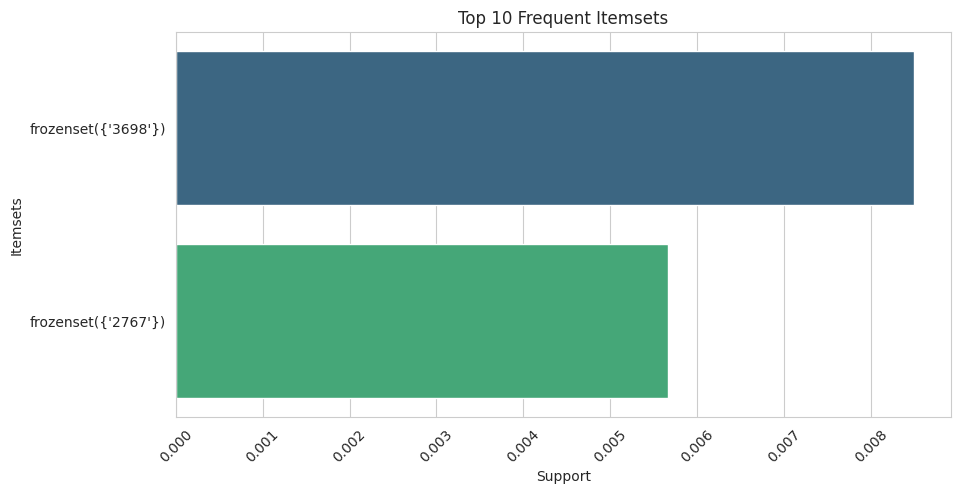

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

#  **Plot Frequent Itemsets**
plt.figure(figsize=(10, 5))
top_items = frequent_itemsets.nlargest(10, 'support')  # Get Top 10
sns.barplot(data=top_items, x='support', y=top_items['itemsets'].astype(str), palette='viridis')
plt.xlabel('Support')
plt.ylabel('Itemsets')
plt.title('Top 10 Frequent Itemsets')
plt.xticks(rotation=45)
plt.show()
